# Metaphor Detection and Domain Relevance Classification

`Melina Paxinou`

MA Linguistics, Text Mining - Vrije Universiteit Amsterdam

June 27, 2025

## Imports

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import pandas as pd
import spacy
import numpy as np
nlp = spacy.load("en_core_web_md")
from openpyxl.utils.exceptions import IllegalCharacterError
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import RobertaTokenizerFast
import random
import os
from rapidfuzz.fuzz import ratio
from functools import lru_cache
from tqdm import tqdm
import xml.etree.ElementTree as ET
import re
from sklearn.metrics import recall_score
import itertools
from itertools import combinations
from datasets import Dataset
import ast

In [3]:
device = torch.device('cuda')

print('Connected to GPU:', torch.cuda.get_device_name(0))

Connected to GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [19]:
model_name = "lwachowiak/Metaphor-Detection-XLMR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
id2label = model.config.id2label

In [20]:
label_list= ['literal',"metaphoric"]
label_dict_relations={ i : l for i, l in enumerate(label_list) }
other_model_name="allenai/biomed_roberta_base"
PATH = "../lwahowiak/Multilingual-Metaphor-Detection-main/saved-models/metaphor_extraction_2025-04-15_randVal-True_allenai/biomed_roberta_base"
model_metaphor_detection = AutoModelForTokenClassification.from_pretrained(PATH, id2label=label_dict_relations)
other_tokenizer = RobertaTokenizerFast.from_pretrained(other_model_name, add_prefix_space=True)

## XLM-R to manual annotations

In [23]:
manual_test_file = 'test_sentences_anno.xlsx'

In [25]:
manual_test_df = pd.read_excel(manual_test_file, header=0)

In [27]:
manual_test_df['token_text'] = manual_test_df['token_text'].fillna('[empty]').replace('', '[empty]')

grouped = manual_test_df.groupby(["sentence_id", "text_id"])


In [31]:
all_preds = []

for (text_id, sentence_id), group in grouped:
    tokens = group['token_text'].tolist()
    # print(f"Text: {text_id}, Sentence: {sentence_id}, Tokens: {tokens}")
    tokens = [str(t) for t in tokens]

    inputs = tokenizer([tokens], is_split_into_words=True, return_tensors="pt", truncation=True)
    word_ids = inputs.word_ids()

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).squeeze().tolist()
    id2label = model.config.id2label

    token_preds = []
    prev_word_id = None
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id == prev_word_id:
            continue
        label = id2label[predictions[idx]]
        token_preds.append(label)
        prev_word_id = word_id

    all_preds.extend(token_preds)


In [32]:
manual_test_df["metaphor_label"] = all_preds

In [33]:
gold = manual_test_df['FINAL']

In [34]:
manual_test_df["metaphor_label"]

0      LABEL_0
1      LABEL_0
2      LABEL_0
3      LABEL_0
4      LABEL_0
        ...   
757    LABEL_0
758    LABEL_0
759    LABEL_0
760    LABEL_1
761    LABEL_1
Name: metaphor_label, Length: 762, dtype: object

## BioMed-RoBERTa to manual annotations

In [36]:
label_list= ['literal',"metaphoric"]
label_dict_relations={ i : l for i, l in enumerate(label_list) }

In [37]:
other_all_preds = []

for sentence_id, group in grouped:
    tokens = group['token_text'].tolist()
    tokens = [str(t) for t in tokens]

    inputs = other_tokenizer([tokens], is_split_into_words=True, return_tensors="pt", truncation=True)
    word_ids = inputs.word_ids()

    with torch.no_grad():
        outputs = model_metaphor_detection(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).squeeze().tolist()
    id2label = model_metaphor_detection.config.id2label

    other_token_preds = []
    prev_word_id = None
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id == prev_word_id:
            continue
        label = id2label[predictions[idx]]
        other_token_preds.append(label)
        prev_word_id = word_id

    other_all_preds.extend(other_token_preds)

In [38]:
manual_test_df["bio_metaphor_label"] = other_all_preds

In [39]:
manual_test_df["bio_metaphor_label"]

0         literal
1         literal
2         literal
3         literal
4      metaphoric
          ...    
757    metaphoric
758       literal
759       literal
760       literal
761       literal
Name: bio_metaphor_label, Length: 762, dtype: object

## Evaluation

In [41]:
def map_label_to_binary(label):
    if label in ["literal", "LABEL_0"]:
        return 0
    elif label in ["metaphoric", "LABEL_1"]:
        return 1
    else:
        raise ValueError(f"Unknown label: {label}")
        
def evaluate_binary_classification(y_true, y_pred, pos_tags=None):
    """
    y_true: list of gold labels (0.0 or 1.0)
    y_pred: list of predicted labels ("literal", "metaphoric", "LABEL_0", "LABEL_1")
    pos_tags: optional list of POS tags; if provided, will skip irrelevant POS
    """

    skip_pos = {
        'ADP', # adposition
        'AUX', # auxiliary
        'CCONJ', # coordinating conjunction
        'DET', # determiner
        'NUM', # numeral
        'PART', # particle
        'PRON', # pronoun
        'PUNCT', # punctuation
        'SCONJ', # subordinating conjunction
        'SPACE', # space
        'SYM', # symbol
        'X' # other
    }

    if isinstance(pos_tags, pd.Series):
        pos_tags = pos_tags.tolist()

    if pos_tags:
        if not (len(y_true) == len(y_pred) == len(pos_tags)):
            raise ValueError("y_true, y_pred, and pos_tags must be the same length.")
        
        filtered = []
        for idx, (yt, yp, pos) in enumerate(zip(y_true, y_pred, pos_tags)):
            if yt is None or yp is None or pos is None or yt == '' or yp == '' or pos == '':
                print(f"Empty cell found at index {idx}: y_true='{yt}', y_pred='{yp}', pos='{pos}'")
            elif yt not in [0.0, 1.0] or yp not in ["LABEL_0", "LABEL_1", "literal", "metaphoric"]:
                print(f"Invalid label found at index {idx}: y_true='{yt}', y_pred='{yp}', pos='{pos}'")
            elif pos not in skip_pos:
                filtered.append((yt, yp))

        y_true_filtered, y_pred_filtered = zip(*filtered) if filtered else ([], [])
    else:
        filtered = []
        for idx, (yt, yp) in enumerate(zip(y_true, y_pred)):
            if yt is None or yp is None or yt == '' or yp == '':
                print(f"Empty cell found at index {idx}: y_true='{yt}', y_pred='{yp}'")
            elif yt not in [0.0, 1.0] or yp not in ["LABEL_0", "LABEL_1", "literal", "metaphoric"]:
                print(f"Invalid label found at index {idx}: y_true='{yt}', y_pred='{yp}'")
            else:
                filtered.append((yt, yp))
        
        y_true_filtered, y_pred_filtered = zip(*filtered) if filtered else ([], [])

    y_pred_binary = [map_label_to_binary(label) for label in y_pred_filtered]

    print(f"\nEvaluating on {len(y_pred_binary)} tokens.\n")
    print("Classification Report:\n")
    print(classification_report(y_true_filtered, y_pred_binary, digits=3, target_names=["Not Metaphor", "Metaphor"]))

    cm = confusion_matrix(y_true_filtered, y_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=["Not Metaphor", "Metaphor"],
                yticklabels=["Not Metaphor", "Metaphor"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [43]:
pos = manual_test_df['pos']


Evaluating on 390 tokens.

Classification Report:

              precision    recall  f1-score   support

Not Metaphor      0.907     0.915     0.911       340
    Metaphor      0.383     0.360     0.371        50

    accuracy                          0.844       390
   macro avg      0.645     0.637     0.641       390
weighted avg      0.840     0.844     0.842       390



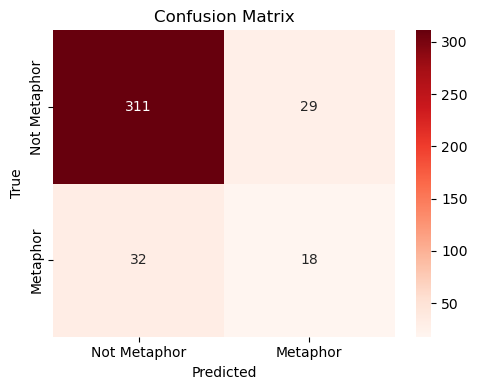

In [199]:
evaluate_binary_classification(gold, all_preds, pos_tags=pos)


Evaluating on 390 tokens.

Classification Report:

              precision    recall  f1-score   support

Not Metaphor      0.912     0.909     0.910       340
    Metaphor      0.392     0.400     0.396        50

    accuracy                          0.844       390
   macro avg      0.652     0.654     0.653       390
weighted avg      0.845     0.844     0.844       390



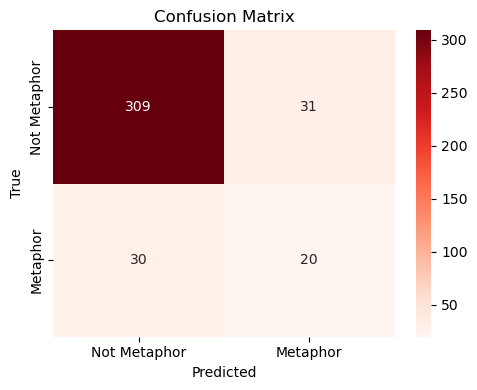

In [201]:
evaluate_binary_classification(gold, other_all_preds, pos_tags=pos)

In [50]:
def print_fp_fn_by_pos(
    df,
    pred_col,
    pos_col='pos',
    gold_col='FINAL',
    token_col='token_text',
    token_id_col='token_id',
    model_name="Model"
):
    """
    Returns tuples of False Positives, False Negatives, and True Positives
    for a given model, excluding tokens based on POS.

    Prints the errors.

    Returns:
        Tuple: (fp, fn, tp)
    """

    skip_pos = {
        'ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON',
        'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'X'
    }

    predictions_fp = []
    predictions_fn = []
    predictions_tp = []

    for _, row in df.iterrows():
        if row[pred_col] in ['LABEL_1', 'metaphoric'] and row[gold_col] == 0:
            if row[pos_col] not in skip_pos:
                predictions_fp.append(row[token_col])

    for _, row in df.iterrows():
        if row[pred_col] in ['LABEL_0', 'literal'] and row[gold_col] == 1:
            if row[pos_col] not in skip_pos:
                predictions_fn.append(row[token_col])

    for _, row in df.iterrows():
        if row[pred_col] in ['LABEL_1', 'metaphoric'] and row[gold_col] == 1:
            if row[pos_col] not in skip_pos:
                predictions_tp.append(row[token_col])

    return predictions_fp, predictions_fn, predictions_tp


fp_xlm, fn_xlm, tp_xlm = print_fp_fn_by_pos(
    manual_test_df,
    pred_col='metaphor_label',
    pos_col='pos',
    model_name='XLM-R'
)

fp_bio, fn_bio, tp_bio = print_fp_fn_by_pos(
    manual_test_df,
    pred_col='bio_metaphor_label',
    pos_col='pos',
    model_name='BioMed'
)

max_len = max(len(fp_xlm), len(fp_bio), len(fn_xlm), len(fn_bio))

fp_xlm += [''] * (max_len - len(fp_xlm))
fp_bio += [''] * (max_len - len(fp_bio))
fn_xlm += [''] * (max_len - len(fn_xlm))
fn_bio += [''] * (max_len - len(fn_bio))

fp_xlm_set = set(fp_xlm) - {''}
fp_bio_set = set(fp_bio) - {''}

fn_xlm_set = set(fn_xlm) - {''}
fn_bio_set = set(fn_bio) - {''}

def bold_if_unique(word, other_set):
    if word and word not in other_set:
        return f"**{word}**"
    else:
        return word

fp_xlm_fmt = [bold_if_unique(w, fp_bio_set) for w in fp_xlm]
fp_bio_fmt = [bold_if_unique(w, fp_xlm_set) for w in fp_bio]

fn_xlm_fmt = [bold_if_unique(w, fn_bio_set) for w in fn_xlm]
fn_bio_fmt = [bold_if_unique(w, fn_xlm_set) for w in fn_bio]

fp_fn_table = pd.DataFrame({
    'XLM-R FP': fp_xlm_fmt,
    'BioMed FP': fp_bio_fmt,
    'XLM-R FN': fn_xlm_fmt,
    'BioMed FN': fn_bio_fmt
})

print("\n=== FP/FN Comparison Table (Bold = Unique) ===\n")
print(fp_fn_table.to_markdown(index=False))



=== FP/FN Comparison Table (Bold = Unique) ===

| XLM-R FP          | BioMed FP        | XLM-R FN         | BioMed FN      |
|:------------------|:-----------------|:-----------------|:---------------|
| adverse           | **future**       | epidemic         | epidemic       |
| therapy           | adverse          | events           | events         |
| Cancer            | therapy          | checkpoint       | checkpoint     |
| CPIs              | Cancer           | checkpoint       | landscape      |
| **mainly**        | CPIs             | landscape        | growing        |
| lung              | lung             | growing          | number         |
| prevention        | prevention       | number           | mechanism      |
| **environmental** | **CURE**         | mechanism        | looks          |
| Survival          | Survival         | looks            | covering       |
| %                 | %                | covering         | outlining      |
| drug              | drug 

In [ ]:
def print_highlighted_sentences_by_pos(
    df,
    pred_col,
    pos_col='pos',
    gold_col='FINAL',
    token_col='token_text',
    sent_col='sentence_id',
    model_name="Model"
):
    """
    For each sentence, prints the full sentence with FP, FN, and TP tokens highlighted.

    Returns:
        None (prints output)
    """

    skip_pos = {
        'ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON',
        'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'X'
    }

    def get_error_type(row):
        pred = row[pred_col]
        gold = row[gold_col]
        pos = row[pos_col]

        if pos in skip_pos:
            return 'OK'  

        if pred in ['LABEL_1', 'metaphoric'] and gold == 0:
            return 'FP'
        elif pred in ['LABEL_0', 'literal'] and gold == 1:
            return 'FN'
        elif pred in ['LABEL_1', 'metaphoric'] and gold == 1:
            return 'TP'
        else:
            return 'OK'

    df = df.copy()
    df['error_type'] = df.apply(get_error_type, axis=1)

    grouped = df.groupby(sent_col)

    print(f"\n=== {model_name} Highlighted Sentences (FP=*, FN=~, TP=`) ===\n")

    for sent_id, group in grouped:
        highlighted_tokens = []
        for _, row in group.iterrows():
            token = row[token_col]
            error = row['error_type']

            if error == 'FP':
                token = f"*{token}*"
            elif error == 'FN':
                token = f"~{token}~"
            elif error == 'TP':
                token = f"`{token}`"

            highlighted_tokens.append(token)

        sentence = ' '.join(highlighted_tokens)
        print(f"Sentence ID {sent_id}:")
        print(sentence)
        print()

print_highlighted_sentences_by_pos(
    manual_test_df,
    pred_col='metaphor_label',
    pos_col='pos',
    sent_col='sentence_id',
    model_name='XLM-R'
)

print_highlighted_sentences_by_pos(
    manual_test_df,
    pred_col='bio_metaphor_label',
    pos_col='pos',
    sent_col='sentence_id',
    model_name='BioMed'
)


## Full Pipeline

In [55]:
def convert_token_level_to_sentence_level(
    df_or_path, output_path=None, prediction_col=None, pos_col='pos'
):

    """
    Converts token-level metaphor predictions to sentence-level entries, 
    selecting only metaphorical tokens with relevant POS tags.

    Parameters
    ----------
    df_or_path : str or pandas.DataFrame
        Path to a TSV, TXT, or Excel file containing token-level predictions, 
        or a pandas DataFrame with the same structure.

    output_path : str
        If provided, saves the resulting sentence-level DataFrame as a TSV file to this path.

    prediction_col : str
        Name of the column containing the metaphor prediction labels 
        (e.g., 'metaphor_pred'). Supports 'literal', 'metaphoric', 'LABEL_0', 'LABEL_1', or 0/1.

    pos_col : str, default='pos'
        Name of the column containing POS tags.

    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row corresponds to a metaphorically tagged token (with valid POS) 
        within its full sentence context. Includes tokenized sentence, token index, POS, and relevance.
    """
    
    skip_pos = {
        'ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON',
        'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'X'
    }

    if isinstance(df_or_path, str):
        _, ext = os.path.splitext(df_or_path)
        if ext.lower() in ['.xls', '.xlsx']:
            df = pd.read_excel(df_or_path)
        elif ext.lower() in ['.tsv', '.txt']:
            df = pd.read_csv(df_or_path, sep='\t')
        else:
            raise ValueError("Unsupported file format.")
    elif isinstance(df_or_path, pd.DataFrame):
        df = df_or_path.copy()
    else:
        raise TypeError("df_or_path must be a DataFrame or a path to a file.")

    sentence_col = 'sentence_number' if 'sentence_number' in df.columns else 'sentence_id'
    metaphor_col = prediction_col
    text_id_available = 'text_id' in df.columns

    label_map = {
        'literal': 0,
        'metaphoric': 1,
        'LABEL_0': 0,
        'LABEL_1': 1,
        0: 0,
        1: 1,
    }

    if df[metaphor_col].dtype == object:
        df[metaphor_col] = df[metaphor_col].map(lambda x: label_map.get(x, None))
    if df[metaphor_col].isnull().any():
        raise ValueError("Found unknown labels in the prediction column after mapping.")

    required_columns = {sentence_col, metaphor_col, 'token_text', 'is_it_relevant', pos_col}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"Missing required columns: {missing}")

    group_cols = ['text_id', sentence_col] if text_id_available else [sentence_col]
    sentence_level_data = []
    grouped = df.groupby(group_cols, sort=False)

    for group_keys, group in grouped:
        tokens = group['token_text'].tolist()
        metaphors = group[metaphor_col].tolist()
        relevances = group['is_it_relevant'].tolist()
        pos_tags = group[pos_col].tolist()

        for i, (is_metaphor, pos_tag) in enumerate(zip(metaphors, pos_tags)):
            if is_metaphor == 1 and pos_tag not in skip_pos:
                sentence_info = {
                    sentence_col: group[sentence_col].iloc[0],
                    'sentence_tokens': tokens,
                    'target_token_index': i,
                    'is_metaphor': 1,
                    'is_it_relevant': int(relevances[i]),
                    'pos': pos_tag,
                }
                if text_id_available:
                    sentence_info['text_id'] = group['text_id'].iloc[0]

                sentence_level_data.append(sentence_info)

    result_df = pd.DataFrame(sentence_level_data)

    if output_path:
        result_df.to_csv(output_path, sep='\t', index=False)

    return result_df


In [56]:
manual_test_df['is_it_relevant'] = manual_test_df['is_it_relevant'].fillna(0)
sentence_df = convert_token_level_to_sentence_level(manual_test_df, output_path='test_thing.tsv', prediction_col='metaphor_label')

In [57]:
bio_sentence_df = convert_token_level_to_sentence_level(manual_test_df, output_path='bio_test_thing.tsv', prediction_col='bio_metaphor_label')

In [58]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer

load_model = AutoModelForTokenClassification.from_pretrained("bert/model_")
load_tokenizer = AutoTokenizer.from_pretrained("bert/model_")
args = TrainingArguments(output_dir="bert/model_")
load_trainer = Trainer(model=load_model, args=args, tokenizer=load_tokenizer)


C:\Users\melou\AppData\Local\Temp\ipykernel_27728\75132900.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  load_trainer = Trainer(model=load_model, args=args, tokenizer=load_tokenizer)


In [59]:
label_list= ['literal', 'metaphoric']
label_dict_relations = {i: l for i, l in enumerate(label_list)}
label2id = {v: k for k, v in label_dict_relations.items()}

PATH = "../lwahowiak/Multilingual-Metaphor-Detection-main/saved-models/metaphor_extraction_2025-04-15_randVal-True_allenai/biomed_roberta_base"

other_tokenizer = RobertaTokenizerFast.from_pretrained(PATH, add_prefix_space=True)

other_model = AutoModelForTokenClassification.from_pretrained(PATH, id2label=label_dict_relations, label2id=label2id)

other_training_args = TrainingArguments(output_dir=PATH)

other_trainer = Trainer(model=other_model, args=other_training_args, tokenizer=other_tokenizer)

C:\Users\melou\AppData\Local\Temp\ipykernel_27728\149989320.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  other_trainer = Trainer(model=other_model, args=other_training_args, tokenizer=other_tokenizer)


In [60]:

def mega_function_v2(sentence_tokens, metaphor_idx, tokenizer, max_length=128):
    """
    Preprocesses a single sentence for BERT input.
    Only one word (metaphor target) is labeled. All others get -100.

    Parameters:
    - sentence_tokens: List[str]
    - metaphor_idx: int (index of metaphor word)
    - tokenizer: HuggingFace tokenizer
    - max_length: int (for truncation and padding)

    Returns:
    - tokenized_data: list of dicts with tokenization details
    - final_dataset: Dataset with input_ids, attention_mask, labels
    """
    if metaphor_idx < 0 or metaphor_idx >= len(sentence_tokens):
        raise ValueError("Invalid metaphor_idx")
    raw_labels = [-100] * len(sentence_tokens)
    raw_labels[metaphor_idx] = 1

    tokenized = tokenizer(
        sentence_tokens,
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors=None
    )

    word_ids = tokenized.word_ids()

    aligned_labels = []
    for word_id in word_ids:
        if word_id is None:
            aligned_labels.append(-100)
        else:
            aligned_labels.append(raw_labels[word_id])

    tokenized_data = [{
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": aligned_labels,
        "word_ids": word_ids,
        "tokenized_tokens": tokenizer.convert_ids_to_tokens(tokenized["input_ids"])
    }]

    dataset = Dataset.from_dict({
        "input_ids": [tokenized["input_ids"]],
        "attention_mask": [tokenized["attention_mask"]],
        "labels": [aligned_labels]
    })

    return tokenized_data, dataset


In [61]:
def transform_to_test_sentence_v4(example_dict, trainer, tokenizer, max_length=128):
    """
    Predicts label for metaphor word in a sentence using token classification model.

    Parameters:
    - example_dict: {
        'sentence_tokens': List[str],
        'target_token_index': int
      }
    - trainer
    - tokenizer

    Returns:
    - int: predicted label (0 or 1) for the target word
    """
    sentence_tokens = example_dict["sentence_tokens"]
    
    metaphor_idx = example_dict["target_token_index"]

    tokenized_data, dataset = mega_function_v2(
        sentence_tokens=sentence_tokens,
        metaphor_idx=metaphor_idx,
        tokenizer=tokenizer,
        max_length=max_length
    )

    predictions, _, _ = trainer.predict(dataset)
    pred_labels = np.argmax(predictions, axis=2)

    word_ids = tokenized_data[0]["word_ids"]
    token_preds = pred_labels[0]

    metaphor_token_predictions = [
        pred for wid, pred in zip(word_ids, token_preds) if wid == metaphor_idx
    ]

    if not metaphor_token_predictions:
        raise ValueError("No predictions found for metaphor token index.")

    majority_label = Counter(metaphor_token_predictions).most_common(1)[0][0]
    return majority_label


In [ ]:
def classify_metaphors_from_tsv(tsv_path, trainer, tokenizer):
    """
    Classifies metaphorical usage for tokens in a TSV file using a given trainer and tokenizer.

    Parameters
    ----------
    tsv_path : str
        Path to a TSV file containing sentence tokens and target token indices.

    trainer : transformers.Trainer
        Pretrained trainer used for prediction.

    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer corresponding to the model used in the trainer.

    Returns
    -------
    pandas.DataFrame
        Original dataframe with an added 'predicted_label' column containing model predictions.
    """
    df = pd.read_csv(tsv_path, sep='\t')

    if isinstance(df['sentence_tokens'].iloc[0], str):
        df['sentence_tokens'] = df['sentence_tokens'].apply(ast.literal_eval)

    required_cols = ['sentence_tokens', 'target_token_index']
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns in TSV: {missing}")

    def classify_row(row):
        example = {
            'sentence_tokens': row['sentence_tokens'],
            'target_token_index': int(row['target_token_index'])
        }
        return transform_to_test_sentence_v4(example, trainer, tokenizer)

    df['predicted_label'] = df.apply(classify_row, axis=1)

    return df

classified_df = classify_metaphors_from_tsv('test_thing.tsv', load_trainer, load_tokenizer)
bio_classified_df = classify_metaphors_from_tsv('bio_test_thing.tsv', other_trainer, other_tokenizer)

In [64]:
bio_classified_df.to_csv('bio_test_thing_pred.tsv', sep='\t', index=False, header=True)
classified_df.to_csv('test_thing_pred.tsv', sep='\t', index=False, header=True)

In [150]:
def error_analysis(
    gold_tsv,
    pred_tsv,
    sentence_col='sentence_id',
    token_idx_col='target_token_index',
    gold_label_col='is_it_relevant',
    pred_label_col='predicted_label',
    sentence_tokens_col='sentence_tokens',
    pos_col='pos'
):
    """
    Performs error analysis for relevance prediction.
    Prints TP, TN, FP, FN with details: sentence, token, index, pos, gold, pred.
    """

    def parse_sentence_tokens(token_str):
        try:
            return ast.literal_eval(token_str)
        except:
            return []  
    
    
    gold_df = pd.read_csv(gold_tsv, sep='\t', header=0)
    pred_df = pd.read_csv(pred_tsv, sep='\t', header=0)
    
    gold_df[sentence_tokens_col] = gold_df[sentence_tokens_col].apply(parse_sentence_tokens)
    
    if sentence_tokens_col in pred_df.columns:
        pred_df[sentence_tokens_col] = pred_df[sentence_tokens_col].apply(parse_sentence_tokens)
    
    gold_lookup = {
        (row[sentence_col], row[token_idx_col]): {
            "label": row[gold_label_col],
            "sentence_tokens": row[sentence_tokens_col],
            "pos": row.get(pos_col, "NA")
        }
        for _, row in gold_df.iterrows()
    }

    pred_lookup = {
        (row[sentence_col], row[token_idx_col]): {
            "label": row[pred_label_col],
            "pos": row.get(pos_col, "NA")
        }
        for _, row in pred_df.iterrows()
    }


    TP, TN, FP, FN = [], [], [], []

    all_keys = set(gold_lookup.keys()).union(set(pred_lookup.keys()))

    for key in sorted(all_keys):
        gold_info = gold_lookup.get(key)
        pred_info = pred_lookup.get(key, {"label": 0, "pos": "NA"})
    
        if gold_info is None:
            continue  
    
        gold_label = gold_info["label"]
        pred_label = pred_info["label"]
    
        sent_tokens = gold_info["sentence_tokens"]
        tok_idx = key[1]
        token_text = (
            sent_tokens[tok_idx]
            if isinstance(sent_tokens, list) and 0 <= tok_idx < len(sent_tokens)
            else "?"
        )
    
        entry = {
            "sentence_id": key[0],
            "token_index": tok_idx,
            "token_text": token_text,
            "gold_label": gold_label,
            "pred_label": pred_label,
            "pos": gold_info.get("pos", "NA"),
            "sentence_tokens": sent_tokens,
        }
    
        if gold_label == 1 and pred_label == 1:
            TP.append(entry)
        elif gold_label == 0 and pred_label == 0:
            TN.append(entry)
        elif gold_label == 0 and pred_label == 1:
            FP.append(entry)
        elif gold_label == 1 and pred_label == 0:
            FN.append(entry)


    print(f"\nTotal:\nTP: {len(TP)}, TN: {len(TN)}, FP: {len(FP)}, FN: {len(FN)}")

    # print("\n=== True Positives (TP):c'sentence_tokens']}\n")

    return {
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN
    }


results = error_analysis(
    gold_tsv="baseline/anno_sentences.tsv",
    pred_tsv="test_thing_pred.tsv"
)

bio_results = error_analysis(
    gold_tsv="baseline/anno_sentences.tsv",
    pred_tsv="bio_test_thing_pred.tsv"
)



Total:
TP: 5, TN: 32, FP: 3, FN: 9

Total:
TP: 3, TN: 19, FP: 16, FN: 11


In [67]:
def evaluate_and_store_scores(
    gold_tsv, pred_tsv,
    sentence_col='sentence_id',
    token_idx_col='target_token_index',
    gold_label_col='is_it_relevant',
    pred_label_col='predicted_label',
    pos_col='pos'
):
    """
    Evaluates predictions against gold TSV, filtering by POS, and returns score metrics as DataFrame.

    Returns dictionary with scores. 
    """
    skip_pos = [
        'ADP', 'AUX', 'CCONJ', 'DET', 'NUM', 'PART', 'PRON',
        'PUNCT', 'SCONJ', 'SPACE', 'SYM', 'X'
    ]

    gold_df = pd.read_csv(gold_tsv, sep='\t')
    pred_df = pd.read_csv(pred_tsv, sep='\t')

    gold_df[sentence_col] = gold_df[sentence_col].astype(str)
    gold_df[token_idx_col] = gold_df[token_idx_col].astype(int)
    pred_df[sentence_col] = pred_df[sentence_col].astype(str)
    pred_df[token_idx_col] = pred_df[token_idx_col].astype(int)

    gold_lookup = {
        (row[sentence_col], row[token_idx_col]): row[gold_label_col]
        for _, row in gold_df.iterrows()
    }

    gold_keys = set(
        (row[sentence_col], row[token_idx_col])
        for _, row in gold_df.iterrows()
        if row.get(pos_col, None) not in skip_pos
    )
    pred_keys = set()

    y_true_e2e = []
    y_pred_e2e = []

    for _, row in pred_df.iterrows():
        key = (str(row[sentence_col]), int(row[token_idx_col]))
        pos_tag = row.get(pos_col, None)

        if pos_tag in skip_pos:
            continue

        pred_keys.add(key)
        pred_label = row[pred_label_col]
        gold_label = gold_lookup.get(key, 0)

        y_true_e2e.append(gold_label)
        y_pred_e2e.append(pred_label)

    for key in gold_keys - pred_keys:
        y_true_e2e.append(gold_lookup[key])
        y_pred_e2e.append(0)

    report = classification_report(
        y_true_e2e, y_pred_e2e, digits=3, zero_division=0
    )

    print("\n==== END-TO-END: Detection + Relevance (includes missed metaphors as FN) ====")
    print(report)

    report_dict = classification_report(
        y_true_e2e, y_pred_e2e, output_dict=True, zero_division=0
    )

    score_dict = {
        "literal_precision": report_dict.get("0", {}).get("precision", 0.0),
        "literal_recall": report_dict.get("0", {}).get("recall", 0.0),
        "literal_f1": report_dict.get("0", {}).get("f1-score", 0.0),
        "metaphor_precision": report_dict.get("1", {}).get("precision", 0.0),
        "metaphor_recall": report_dict.get("1", {}).get("recall", 0.0),
        "metaphor_f1": report_dict.get("1", {}).get("f1-score", 0.0),
        "macro_precision": report_dict.get("macro avg", {}).get("precision", 0.0),
        "macro_recall": report_dict.get("macro avg", {}).get("recall", 0.0),
        "macro_f1": report_dict.get("macro avg", {}).get("f1-score", 0.0),
        "support_literal": report_dict.get("0", {}).get("support", 0),
        "support_metaphor": report_dict.get("1", {}).get("support", 0),
    }

    return pd.DataFrame(score_dict, index=[0])



In [68]:
bio_df_chart = evaluate_and_store_scores("baseline/anno_sentences.tsv", "bio_test_thing_pred.tsv")
df_chart = evaluate_and_store_scores("baseline/anno_sentences.tsv", "test_thing_pred.tsv")


==== END-TO-END: Detection + Relevance (includes missed metaphors as FN) ====
              precision    recall  f1-score   support

           0      0.739     0.523     0.613        65
           1      0.088     0.200     0.122        15

    accuracy                          0.463        80
   macro avg      0.414     0.362     0.368        80
weighted avg      0.617     0.463     0.521        80


==== END-TO-END: Detection + Relevance (includes missed metaphors as FN) ====
              precision    recall  f1-score   support

           0      0.830     0.698     0.759        63
           1      0.208     0.357     0.263        14

    accuracy                          0.636        77
   macro avg      0.519     0.528     0.511        77
weighted avg      0.717     0.636     0.669        77



In [69]:
def plot_separate_score_charts(score_df, model1_name, model2_name):
    """
    Plots separate line charts comparing F1, precision, and recall for two models.

    Returns None.
    """

    chart_specs = {
        "F1 Score": ["literal_f1", "metaphor_f1", "macro_f1"],
        "Precision": ["literal_precision", "metaphor_precision", "macro_precision"],
        "Recall": ["literal_recall", "metaphor_recall", "macro_recall"],
    }

    for title, metrics in chart_specs.items():
        values1 = [score_df.loc[model1_name, m] for m in metrics]
        values2 = [score_df.loc[model2_name, m] for m in metrics]
        x = np.arange(len(metrics))

        fig, ax = plt.subplots(figsize=(5, 4))
        ax.plot(x, values1, marker='o', label=model1_name, linewidth=2, color="#f39c12")
        ax.plot(x, values2, marker='o', label=model2_name, linewidth=2, color="#8e44ad")

        for i, val in enumerate(values1):
            ax.text(i, val + 0.015, f"{val:.3f}", ha='center', fontsize=9)
        for i, val in enumerate(values2):
            ax.text(i, val - 0.045, f"{val:.3f}", ha='center', fontsize=9)

        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=30)
        ax.set_ylim(0, 1)
        ax.set_ylabel(title)
        ax.set_title(f"{title} Comparison")
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        ax.legend()
        plt.tight_layout()
        plt.show()


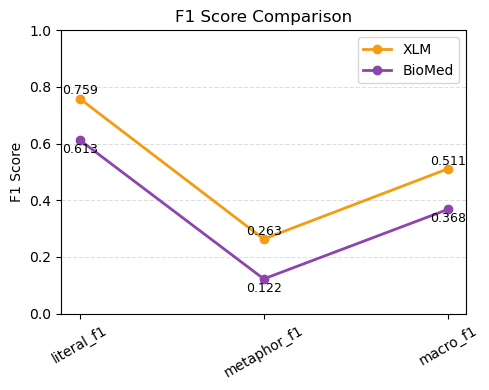

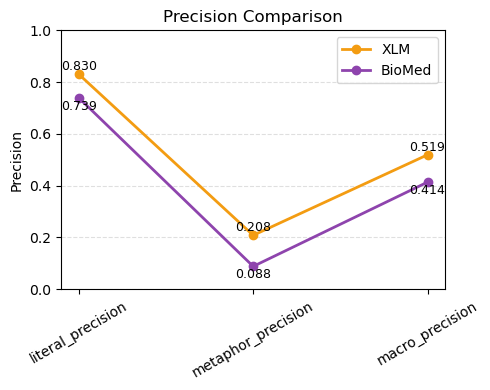

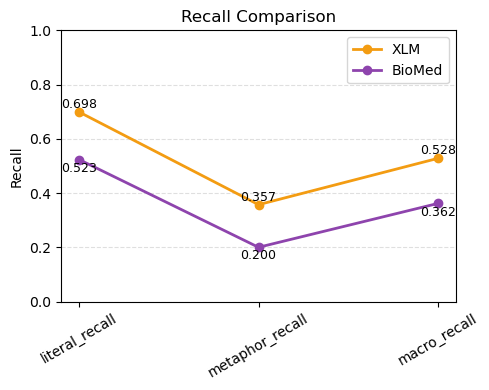

In [70]:
bio_df_chart.index = ["BioMed"]
df_chart.index = ["XLM"]

score_df = pd.concat([df_chart, bio_df_chart], axis=0)

plot_separate_score_charts(score_df, model1_name="XLM", model2_name="BioMed")